In [78]:
import copy

class CheckersGame:
    def __init__(self, board, current_player="red"):
        self.board = board
        self.current_player = current_player

    def generate_legal_moves(self, player):
        """
        Generate all legal moves for the given player.
        First checks for any available captures (which are mandatory).
        If no captures are available, returns regular moves.
        """
        captures = []
        regular_moves = []
        player_pieces = "rR" if player == "red" else "bB"

        # First check for any captures
        for row in range(8):
            for col in range(8):
                piece = self.board[row][col]
                if piece in player_pieces:
                    piece_captures = self._get_captures(row, col, piece, set())
                    if piece_captures:
                        captures.extend(piece_captures)

        # If there are captures available, they are mandatory
        if captures:
            return captures

        # If no captures, get regular moves
        for row in range(8):
            for col in range(8):
                piece = self.board[row][col]
                if piece in player_pieces:
                    moves = self._get_regular_moves(row, col, piece)
                    regular_moves.extend(moves)

        return regular_moves

    def _get_regular_moves(self, row, col, piece):
        """
        Get regular (non-capture) moves for a piece.
        """
        moves = []
        # Define movement directions
        directions = [(-1, -1), (-1, 1), (1, -1), (1, 1)]

        # For kings, they can move any number of steps in a direction
        max_steps = 8 if piece in "RB" else 1

        for dr, dc in directions:
            for step in range(1, max_steps + 1):
                new_row, new_col = row + dr * step, col + dc * step
                if 0 <= new_row < 8 and 0 <= new_col < 8:
                    if self.board[new_row][new_col] == ".":
                        moves.append([(row, col), (new_row, new_col)])
                    else:
                        break  # Blocked by another piece
                else:
                    break  # Out of bounds
        return moves

    def _get_captures(self, row, col, piece, visited):
        """
        Recursively get all possible capture sequences for a piece.
        """
        captures = []
        directions = [(-1, -1), (-1, 1), (1, -1), (1, 1)]

        for dr, dc in directions:
            for step in range(1, 8 if piece in "RB" else 2):
                jump_row, jump_col = row + dr * step, col + dc * step
                land_row, land_col = row + dr * (step + 1), col + dc * (step + 1)

                if (0 <= land_row < 8 and 0 <= land_col < 8 and
                    0 <= jump_row < 8 and 0 <= jump_col < 8 and
                    self.board[jump_row][jump_col] in self._opponent_pieces(piece) and
                    self.board[land_row][land_col] == "." and
                    (jump_row, jump_col) not in visited):

                    new_visited = visited | {(jump_row, jump_col)}
                    further_captures = self._get_captures(land_row, land_col, piece, new_visited)

                    if further_captures:
                        for capture in further_captures:
                            captures.append([(row, col)] + capture)
                    else:
                        captures.append([(row, col), (land_row, land_col)])
        return captures

    def apply_move(self, move):
        """
        Apply a move sequence to the board. Handles both regular moves and capture sequences.
        
        Args:
        - move: List of positions [(start_row, start_col), (pos1_row, pos1_col), ...].
            For regular moves, this will be length 2.
            For capture sequences, this can be longer.
        
        Returns:
        - A new CheckersGame instance with the updated board state
        """
        # Create a deep copy of the board
        new_board = [row[:] for row in self.board]
        
        # Get the moving piece
        start_row, start_col = move[0]
        piece = new_board[start_row][start_col]
        
        # Clear the starting position
        new_board[start_row][start_col] = "."
        
        # Process each step in the move sequence
        for i in range(len(move) - 1):
            current_pos = move[i]
            next_pos = move[i + 1]
            dr = next_pos[0] - current_pos[0]
            dc = next_pos[1] - current_pos[1]
            
            # If this step is a capture (distance > 1)
            if abs(dr) > 1 and abs(dc) > 1:
                # Detect all captured pieces along the jump path
                step_r = dr // abs(dr)  # Direction of row movement
                step_c = dc // abs(dc)  # Direction of column movement
                current_r, current_c = current_pos[0] + step_r, current_pos[1] + step_c
                
                while (current_r != next_pos[0]) and (current_c != next_pos[1]):
                    if self.board[current_r][current_c] in self._opponent_pieces(piece):
                        # Remove captured piece
                        new_board[current_r][current_c] = "."
                    current_r += step_r
                    current_c += step_c
        
        # Place the piece in its final position
        final_row, final_col = move[-1]
        
        # Check for promotion
        if (piece == "r" and final_row == 0) or (piece == "b" and final_row == 7):
            new_board[final_row][final_col] = piece.upper()  # Promote to king
        else:
            new_board[final_row][final_col] = piece
        
        # Switch to the next player
        next_player = "black" if self.current_player == "red" else "red"
        return CheckersGame(new_board, next_player)

    def _opponent_pieces(self, piece):
        """Helper to determine opponent's pieces."""
        return "bB" if piece in "rR" else "rR"
    
    def is_terminal(self):
        """
        Check if the game has reached a terminal state.
        A game is terminal if either:
        1. A player has no pieces left
        2. A player has no legal moves
        3. The game has reached a draw state (no progress possible)
        
        Returns:
        bool: True if the game is in a terminal state, False otherwise
        """
        # Check if either player has no pieces left
        red_pieces = sum(row.count('r') + row.count('R') for row in self.board)
        black_pieces = sum(row.count('b') + row.count('B') for row in self.board)
        
        if red_pieces == 0 or black_pieces == 0:
            return True
            
        # Check if current player has any legal moves
        legal_moves = self.generate_legal_moves(self.current_player)
        if not legal_moves:
            return True
            
        # Check for draw conditions (optional, based on specific rules):
        # 1. Both players only have kings and no captures are possible
        # 2. No progress has been made in last N moves (would need move history)
        only_kings = (sum(row.count('r') + row.count('b') for row in self.board) == 0 and
                    red_pieces + black_pieces > 0)
                    
        if only_kings:
            # Check if any captures are possible for either player
            red_captures = any(len(move) > 2 for move in self.generate_legal_moves("red"))
            black_captures = any(len(move) > 2 for move in self.generate_legal_moves("black"))
            if not (red_captures or black_captures):
                return True
                
        return False


In [44]:
def test_checkers_game():
    # Test 1: Basic board setup and regular moves
    board1 = [
        [".", "b", ".", "b", ".", "b", ".", "b"],
        [".", ".", "b", ".", "b", ".", "b", "."],
        [".", ".", ".", "b", ".", "b", ".", "b"],
        ["b", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", "r", ".", ".", ".", "."],
        ["r", ".", ".", ".", "r", ".", "r", "."],
        [".", "r", ".", "r", ".", "r", ".", "r"],
        ["r", ".", "r", ".", "r", ".", "r", "."]
    ]
    game = CheckersGame(board1, "red")
    r_moves = game.generate_legal_moves("red")
    b_moves = game.generate_legal_moves("black")
    print(r_moves, '\n for black:', b_moves, "END")
    assert len(r_moves) > 0, "Should have valid moves for red pieces"
    # Test 2: Simple Capture
    board2 = [
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", "b", ".", ".", ".", "."],
        [".", ".", "r", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."]
    ]
    game = CheckersGame(board2, "red")
    moves = game.generate_legal_moves("red")
    print(moves) 
    assert len(moves) > 0, "Should have capture move available"
    assert moves[0] == [(4, 2), (2, 4)], "Should capture black piece by jumping over it"
    
    # Test 3: Multiple captures
    board3 = [
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", "b", ".", "b", ".", "."],
        [".", ".", "r", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."]
    ]
    game = CheckersGame(board3, "red")
    moves = game.generate_legal_moves("red")
    assert len(moves) > 0, "Should have multiple capture sequence"
    print('multi capture moves:', moves)
    expected_path = [(4, 2), (2, 4), (4, 6)]
    assert any(move == expected_path for move in moves), "Should have correct multiple capture path"
    
    # Test 4: King moves
    board4 = [
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", "R", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."]
    ]
    game = CheckersGame(board4, "red")
    moves = game.generate_legal_moves("red")
    # Get all possible movement directions for the king
    directions = set()
    for move in moves:
        if len(move) == 2:
            start, end = move
            direction = (end[0] - start[0], end[1] - start[1])
            if abs(direction[0]) == 1:  # Only count immediate diagonal moves
                directions.add(direction)
    assert len(directions) == 4, "King should be able to move in all four diagonal directions"
    
    # Test 5: Promotion
    board5 = [
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", "r", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."]
    ]
    game = CheckersGame(board5, "red")
    moves = game.generate_legal_moves("red")
    promotion_moves = [move for move in moves if move[1][0] == 0]  # Get moves that reach the top row
    assert len(promotion_moves) > 0, "Should have moves that lead to promotion"
    new_game = game.apply_move(promotion_moves[0])
    assert new_game.board[0][promotion_moves[0][1][1]] == "R", "Piece should be promoted to king"
    
    # Test 6: Mandatory capture
    board6 = [
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", "b", ".", ".", ".", "."],
        [".", ".", "r", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", "r", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."]
    ]
    game = CheckersGame(board6, "red")
    moves = game.generate_legal_moves("red")
    print(moves)
    # When a capture is available, it should be the only type of move returned
    assert moves == [[(4, 2), (2, 4)]], "Only capture moves should be available when captures are possible"
    game1 = game.apply_move([(4, 2), (2, 4)])
    print('last test:', game1.board)
    print("All tests passed!")

# Run the tests
if __name__ == "__main__":
    test_checkers_game()

[[(4, 3), (3, 2)], [(4, 3), (3, 4)], [(5, 0), (4, 1)], [(5, 4), (4, 5)], [(5, 6), (4, 5)], [(5, 6), (4, 7)], [(6, 1), (5, 2)], [(6, 3), (5, 2)]] 
 for black: [[(0, 1), (1, 0)], [(1, 2), (2, 1)], [(2, 3), (3, 2)], [(2, 3), (3, 4)], [(2, 5), (3, 4)], [(2, 5), (3, 6)], [(2, 7), (3, 6)], [(3, 0), (4, 1)]] END
[[(4, 2), (2, 4)]]
multi capture moves: [[(4, 2), (2, 4), (4, 6)]]
[[(4, 2), (2, 4)]]
capture detected
captures: 3 3
last test: [['.', '.', '.', '.', '.', '.', '.', '.'], ['.', '.', '.', '.', '.', '.', '.', '.'], ['.', '.', '.', '.', 'r', '.', '.', '.'], ['.', '.', '.', '.', '.', '.', '.', '.'], ['.', '.', '.', '.', '.', '.', '.', '.'], ['.', '.', '.', '.', '.', '.', 'r', '.'], ['.', '.', '.', '.', '.', '.', '.', '.'], ['.', '.', '.', '.', '.', '.', '.', '.']]
All tests passed!


In [51]:
def test_captures():
    board1 = [
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", "b", ".", ".", ".", "."],
        [".", ".", "r", ".", "r", "b", ".", "."],
        [".", ".", ".", ".", ".", ".", "r", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."]
    ]
    game = CheckersGame(board1, "red")
    moves = game.generate_legal_moves("red")
    print(moves)
    # When a capture is available, it should be the only type of move returned
    assert moves == [[(4, 2), (2, 4)], [(4, 4), (2, 2)], [(5, 6), (3, 4)]], "Only capture moves should be available when captures are possible"
    print("All tests passed!")
    
    board2 = [
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", "b", ".", ".", ".", "."],
        [".", ".", "r", ".", "r", "b", ".", "b"],
        [".", ".", ".", ".", ".", ".", "r", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."]
    ]
    game = CheckersGame(board2, "black")
    moves = game.generate_legal_moves("black")
    print(moves)
    # When a capture is available, it should be the only type of move returned
    assert moves == [[(3, 3), (5, 1)], [(3, 3), (5, 5)], [(4, 5), (6, 7)], [(4, 7), (6, 5)]], "Only capture moves should be available when captures are possible"
    print("All tests passed!")

test_captures()

[[(4, 2), (2, 4)], [(4, 4), (2, 2)], [(5, 6), (3, 4)]]
All tests passed!
[[(3, 3), (5, 1)], [(3, 3), (5, 5)], [(4, 5), (6, 7)], [(4, 7), (6, 5)]]
All tests passed!


In [ ]:
def test_kings():
    board1 = [
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", "b", ".", ".", ".", "."],
        [".", ".", "r", ".", "r", "b", ".", "."],
        [".", ".", ".", ".", ".", ".", "r", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."]
    ]
    game = CheckersGame(board1, "red")
    moves = game.generate_legal_moves("red")
    print(moves)
    # When a capture is available, it should be the only type of move returned
    assert moves == [[(4, 2), (2, 4)], [(4, 4), (2, 2)], [(5, 6), (3, 4)]], "Only capture moves should be available when captures are possible"
    print("All tests passed!")
    
    board2 = [
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", "b", ".", ".", ".", "."],
        [".", ".", "r", ".", "r", "b", ".", "b"],
        [".", ".", ".", ".", ".", ".", "r", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."]
    ]
    game = CheckersGame(board2, "black")
    moves = game.generate_legal_moves("black")
    print(moves)
    # When a capture is available, it should be the only type of move returned
    assert moves == [[(3, 3), (5, 1)], [(3, 3), (5, 5)], [(4, 5), (6, 7)], [(4, 7), (6, 5)]], "Only capture moves should be available when captures are possible"
    print("All tests passed!")

test_captures()

In [73]:
import ipywidgets as widgets  # Import widgets for interactive elements
from IPython.display import display  # Import display function to show widgets
import copy  # Import copy to make deep copies of the board
import matplotlib.pyplot as plt  # Import matplotlib for plotting the board
import numpy as np

class CheckersGame:
    def __init__(self, board, current_player="red"):
        """
        Initialize the game with a board state and the current player.
        
        Args:
        - board: A 2D list (8x8) representing the checkers board. 
          Each element can be:
            'r' - red piece
            'b' - black piece
            'R' - red queen
            'B' - black queen
            '.' - empty square
        - current_player: The player whose turn it is ("red" or "black").
        """
        self.board = board
        self.current_player = current_player

   def generate_legal_moves(self, player):
    legal_moves = []
    has_captures = False
    player_pieces = "rR" if player == "red" else "bB"

    for row in range(8):
        for col in range(8):
            piece = self.board[row][col]
            if piece in player_pieces:
                if piece in "rR":
                    directions = [(-1, -1), (-1, 1)]
                else:
                    directions = [(1, -1), (1, 1)]
                if piece in "RB":
                    directions += [(-d[0], -d[1]) for d in directions]

                captures = self._get_captures(row, col, piece, directions, [], set())
                if captures:
                    if not has_captures:
                        legal_moves.clear()
                        has_captures = True
                    legal_moves.extend(captures)
                elif not has_captures:
                    moves = self._get_moves(row, col, piece, directions)
                    legal_moves.extend(moves)
        return legal_moves

    def _get_moves(self, row, col, piece, directions):
        moves = []
        for dr, dc in directions:
            r, c = row + dr, col + dc
            if 0 <= r < 8 and 0 <= c < 8 and self.board[r][c] == ".":
                moves.append([(row, col), (r, c)])
        return moves

    def _get_captures(self, row, col, piece, directions, path, visited):
        captures = []
        has_capture = False
        for dr, dc in directions:
            r, c = row + dr, col + dc
            r2, c2 = r + dr, c + dc
            if (
                0 <= r2 < 8 and 0 <= c2 < 8
                and self.board[r][c] in self._opponent_pieces(piece)
                and self.board[r2][c2] == "."
                and (r, c) not in visited
            ):
                has_capture = True
                new_path = path + [(row, col), (r2, c2)]
                new_visited = visited | {(r, c)}
                further_captures = self._get_captures(r2, c2, piece, directions, new_path, new_visited)
                if further_captures:
                    captures.extend(further_captures)
                else:
                    captures.append(new_path)
        if not has_capture and path:
            return [path]
        return captures

     
    def _get_piece_moves(self, row, col, piece, directions):
        """
        Helper method to generate legal moves for a single piece.
        
        Args:
        - row, col: The position of the piece on the board.
        - piece: The type of piece ('r', 'b', 'R', 'B').
        - directions: List of movement directions for this piece.
        
        Returns:
        - A list of legal moves for this piece.
        """
        moves = []  # Stores valid moves for this piece
        for dr, dc in directions:
            # Calculate the destination for a simple move
            r, c = row + dr, col + dc
            # Ensure the destination is within bounds and empty
            if 0 <= r < 8 and 0 <= c < 8 and self.board[r][c] == ".":
                moves.append(((row, col), (r, c)))  # Add the move to the list

            # Check for capture moves
            r2, c2 = r + dr, c + dc  # Position after jumping over an opponent's piece
            if (
                0 <= r2 < 8 and 0 <= c2 < 8  # Ensure capture destination is within bounds
                and self.board[r][c] in self._opponent_pieces(piece)  # Check if the intervening piece is an opponent
                and self.board[r2][c2] == "."  # Ensure the landing square is empty
            ):
                moves.append(((row, col), (r2, c2)))  # Add the capture move
                # Recursively check for additional captures
                self._recursive_capture_moves(r2, c2, piece, directions, moves, [(row, col), (r2, c2)])

        return moves

    def _recursive_capture_moves(self, row, col, piece, directions, moves, path):
        """
        Recursively generate all possible capture moves for a piece.
        
        Args:
        - row, col: The current position of the piece on the board.
        - piece: The type of piece ('r', 'b', 'R', 'B').
        - directions: List of movement directions for this piece.
        - moves: List to store the generated moves.
        - path: The current path of the piece.
        """
        for dr, dc in directions:
            r, c = row + dr, col + dc
            r2, c2 = r + dr, c + dc
            if (
                0 <= r2 < 8 and 0 <= c2 < 8
                and self.board[r][c] in self._opponent_pieces(piece)
                and self.board[r2][c2] == "."
            ):
                new_path = path + [(r2, c2)]
                moves.append((path[0], (r2, c2)))
                self._recursive_capture_moves(r2, c2, piece, directions, moves, new_path)

        return moves

    def apply_move(self, move):
        """
        Apply a move to the current board state and return the resulting game state.
        
        Args:
        - move: A tuple ((start_row, start_col), (end_row, end_col)).
        
        Returns:
        - A new CheckersGame instance with the updated board and player turn.
        """
        start, end = move
        start_row, start_col = start
        end_row, end_col = end

        # Make a copy of the board to avoid modifying the original state
        new_board = [row[:] for row in self.board]
        piece = new_board[start_row][start_col]

        # Move the piece to the new position
        new_board[start_row][start_col] = "."  # Clear the starting square
        new_board[end_row][end_col] = piece  # Place the piece in the destination square

        # Handle captures: If the move is a jump (distance of 2)
        if abs(end_row - start_row) == 2:
            captured_row = (start_row + end_row) // 2
            captured_col = (start_col + end_col) // 2
            new_board[captured_row][captured_col] = "."  # Remove the captured piece

        # Handle promotion to queen (if the piece reaches the opponent's back row)
        if end_row == 0 and piece == "r":  # Red promotion
            new_board[end_row][end_col] = "R"
        elif end_row == 7 and piece == "b":  # Black promotion
            new_board[end_row][end_col] = "B"

        # Switch to the next player
        next_player = "black" if self.current_player == "red" else "red"
        return CheckersGame(new_board, current_player=next_player)

    def evaluate(self, player):
        """
        Evaluate the board state for the given player.
        
        Args:
        - player: The player to evaluate ("red" or "black").
        
        Returns:
        - A numerical score indicating the player's advantage. Higher is better for the player.
        """
        opponent = "black" if player == "red" else "red"
        # Material advantage: Each queen is worth 3, each regular piece is worth 1
        player_score = (
            3 * self.count_pieces(player, queens=True) + self.count_pieces(player)
        )
        opponent_score = (
            3 * self.count_pieces(opponent, queens=True) + self.count_pieces(opponent)
        )
        return player_score - opponent_score

    def count_pieces(self, player, queens=False):
        """
        Count the number of pieces or queens for the given player.
        
        Args:
        - player: The player ("red" or "black").
        - queens: If True, count only queens. If False, count all pieces.
        
        Returns:
        - The count of the specified pieces.
        """
        pieces = "rR" if player == "red" else "bB"  # Determine the player's pieces
        if queens:
            pieces = pieces.upper()  # Only count queens
        return sum(1 for row in self.board for cell in row if cell in pieces)

    def is_terminal(self):
        """
        Check if the game has reached a terminal state (win, loss, or draw).
        
        Returns:
        - True if the game is over, False otherwise.
        """
        # Game is over if a player has no pieces left
        if self.count_pieces("red") == 0 or self.count_pieces("black") == 0:
            return True

        # Game is over if the current player has no legal moves
        if not self.generate_legal_moves(self.current_player):
            return True

        return False

    def _opponent_pieces(self, piece):
        """
        Helper to determine the opponent's pieces based on the given piece.
        
        Args:
        - piece: The player's piece ('r', 'b', 'R', 'B').
        
        Returns:
        - A string of the opponent's pieces ('bB' for 'rR', or 'rR' for 'bB').
        """
        return "bB" if piece in "rR" else "rR"

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 25)

In [8]:
def alpha_beta_pruning(game, depth, alpha, beta, maximizing_player):
    """
    Perform the Alpha-Beta Pruning algorithm to determine the best move.

    Args:
    - game: An instance of the CheckersGame class, representing the current game state.
    - depth: The maximum depth to search in the game tree.
    - alpha: The best score that the maximizing player is assured of so far.
    - beta: The best score that the minimizing player is assured of so far.
    - maximizing_player: True if the current player is maximizing; False otherwise.

    Returns:
    - A tuple (best_score, best_move) where:
        - best_score: The evaluation score of the best move found.
        - best_move: The move that leads to the best_score.
    """
    # Base case: If we have reached the maximum depth or the game is over
    if depth == 0 or game.is_terminal():
        # Evaluate the board state for the current player
        evaluation = game.evaluate(game.current_player)
        return evaluation, None

    # Get all legal moves for the current player
    legal_moves = game.generate_legal_moves(game.current_player)

    # If no moves are possible, this is effectively a terminal state
    if not legal_moves:
        evaluation = game.evaluate(game.current_player)
        return evaluation, None

    # Initialize variables to track the best score and move
    best_move = None

    # If the current player is the maximizing player
    if maximizing_player:
        max_eval = float('-inf')  # Initialize to the worst possible score

        # Loop through all possible moves
        for move in legal_moves:
            # Apply the move to get a new game state
            new_game = game.apply_move(move)

            # Recursively call alpha-beta pruning for the opponent's turn
            eval_score, _ = alpha_beta_pruning(new_game, depth - 1, alpha, beta, False)

            # Update the best score and move if this move is better
            if eval_score > max_eval:
                max_eval = eval_score
                best_move = move

            # Update alpha with the best score found so far
            alpha = max(alpha, eval_score)

            # Prune the search tree if beta <= alpha
            if beta <= alpha:
                break

        return max_eval, best_move

    else:  # The current player is the minimizing player
        min_eval = float('inf')  # Initialize to the worst possible score

        # Loop through all possible moves
        for move in legal_moves:
            # Apply the move to get a new game state
            new_game = game.apply_move(move)

            # Recursively call alpha-beta pruning for the opponent's turn
            eval_score, _ = alpha_beta_pruning(new_game, depth - 1, alpha, beta, True)

            # Update the best score and move if this move is better
            if eval_score < min_eval:
                min_eval = eval_score
                best_move = move

            # Update beta with the best score found so far
            beta = min(beta, eval_score)

            # Prune the search tree if beta <= alpha
            if beta <= alpha:
                break

        return min_eval, best_move

In [9]:
def alpha_beta_search(game, depth, max_depth=6):
    """
    Wrapper function to start the alpha-beta search.
    Returns the best move and its evaluated score.
    """
    alpha = float('-inf')
    beta = float('inf')
    best_move = None
    best_value = float('-inf')
    
    # Get all possible moves for the current player
    moves = game.generate_legal_moves(game.current_player)
    
    # If no moves are available, return None
    if not moves:
        return None, float('-inf')
    
    # Try each move and find the one with the highest value
    for move in moves:
        # Apply the move and get the resulting game state
        next_state = game.apply_move(move)
        
        # Get the value for this move
        value = -alpha_beta_min(next_state, depth - 1, max_depth, -beta, -alpha)
        
        # Update best move if this one is better
        if value > best_value:
            best_value = value
            best_move = move
        
        alpha = max(alpha, value)
        
    return best_move, best_value

def alpha_beta_max(game, depth, max_depth, alpha, beta):
    """
    Maximizing player in alpha-beta pruning.
    Returns the highest value achievable from this position.
    """
    # Check terminal conditions
    if depth == 0 or game.is_terminal():
        return evaluate_position(game, max_depth - depth)
    
    value = float('-inf')
    moves = game.generate_legal_moves(game.current_player)
    
    for move in moves:
        next_state = game.apply_move(move)
        value = max(value, -alpha_beta_min(next_state, depth - 1, max_depth, -beta, -alpha))
        alpha = max(alpha, value)
        if alpha >= beta:
            break  # Beta cutoff
    
    return value

def alpha_beta_min(game, depth, max_depth, alpha, beta):
    """
    Minimizing player in alpha-beta pruning.
    Returns the lowest value achievable from this position.
    """
    # Check terminal conditions
    if depth == 0 or game.is_terminal():
        return evaluate_position(game, max_depth - depth)
    
    value = float('inf')
    moves = game.generate_legal_moves(game.current_player)
    
    for move in moves:
        next_state = game.apply_move(move)
        value = min(value, -alpha_beta_max(next_state, depth - 1, max_depth, -beta, -alpha))
        beta = min(beta, value)
        if beta <= alpha:
            break  # Alpha cutoff
    
    return value

def evaluate_position(game, depth_remaining):
    """
    Evaluate the current game position from the perspective of the current player.
    
    Args:
    game: CheckersGame instance
    depth_remaining: Number of plies remaining in search (used for move ordering)
    
    Returns:
    float: Score for the position (higher is better for current player)
    """
    current_player = game.current_player
    opponent = "black" if current_player == "red" else "red"
    
    # Count material
    player_pieces = sum(row.count(current_player[0]) for row in game.board)  # Regular pieces
    player_kings = sum(row.count(current_player[0].upper()) for row in game.board)  # Kings
    opponent_pieces = sum(row.count(opponent[0]) for row in game.board)
    opponent_kings = sum(row.count(opponent[0].upper()) for row in game.board)
    
    # Material score (kings worth 2x regular pieces)
    material_score = (player_pieces + 2 * player_kings) - (opponent_pieces + 2 * opponent_kings)
    
    # Position scoring
    position_score = 0
    board_size = len(game.board)
    
    for i in range(board_size):
        for j in range(board_size):
            piece = game.board[i][j]
            if piece in (current_player[0], current_player[0].upper()):
                # Reward advancing pieces
                if current_player == "red":
                    position_score += (board_size - i) * 0.1  # Red wants to advance toward row 0
                else:
                    position_score += i * 0.1  # Black wants to advance toward row 7
                
                # Reward pieces near the center
                center_distance = abs(3.5 - j)
                position_score += (4 - center_distance) * 0.05
                
                # Reward pieces near promotion
                if piece == current_player[0]:  # Only for regular pieces
                    if (current_player == "red" and i == 1) or (current_player == "black" and i == 6):
                        position_score += 0.5
    
    # Mobility score (number of legal moves available)
    mobility_score = len(game.generate_legal_moves(current_player)) * 0.1
    
    # Combine all factors
    total_score = (
        material_score * 10.0 +  # Material is most important
        position_score +         # Position provides refinement
        mobility_score          # Mobility helps break ties
    )
    
    # Adjust score based on depth (prefer winning sooner / losing later)
    if total_score > 0:
        total_score += depth_remaining * 0.01
    elif total_score < 0:
        total_score -= depth_remaining * 0.01
    
    return total_score

In [10]:
def test_alpha_beta_1():
    # Create a test board with an obvious capture
    test_board = [
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", "b", ".", ".", ".", "."],
        [".", "r", "r", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        ["r", ".", ".", "r", ".", ".", "r", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."]
    ]
    
    game = CheckersGame(test_board, "red")
    best_move, value = alpha_beta_search(game, depth=4)
    
    # The best move should be the capture
    expected_move = [(3, 2), (1, 4)]
    assert best_move == expected_move, f"Expected {expected_move}, got {best_move}"
    print("Alpha-beta pruning test passed!")
    return best_move, value

if __name__ == "__main__":
    best_move, value = test_alpha_beta_1()
    print(f"Best move: {best_move}")
    print(f"Position value: {value}")
    

def test_alpha_beta_2():
    # Create a test board with an obvious capture
    test_board = [
        ["r", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", "b", ".", "b", ".", ".", "."],
        [".", "r", "r", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        ["r", ".", ".", "r", ".", ".", "r", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."]
    ]
    
    game = CheckersGame(test_board, "red")
    best_move, value = alpha_beta_search(game, depth=4)
    
    # The best move should be the capture
    expected_move = [(3, 1), (1, 3), (3, 5)]
    assert best_move == expected_move, f"Expected {expected_move}, got {best_move}"
    print("Alpha-beta pruning test passed!")
    return best_move, value

if __name__ == "__main__":
    best_move, value = test_alpha_beta_2()
    print(f"Best move: {best_move}")
    print(f"Position value: {value}")


def test_alpha_beta_3():
    # Create a test board with an obvious capture
    test_board = [
        ["r", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", "b", ".", "b", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", "r", ".", ".", ".", ".", "."],
        ["r", ".", ".", "r", ".", ".", "r", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."]
    ]
    
    game = CheckersGame(test_board, "red")
    best_move, value = alpha_beta_search(game, depth=4)
    
    # The best move should be the capture
    expected_move = [(4, 2), (3, 3)]
    assert best_move == expected_move, f"Expected {expected_move}, got {best_move}"
    print("Alpha-beta pruning test passed!")
    return best_move, value

#if __name__ == "__main__":
 #   best_move, value = test_alpha_beta_3()
 #   print(f"Best move: {best_move}")
#    print(f"Position value: {value}")


def test_alpha_beta_4():
    # Create a test board with an obvious capture
    test_board = [
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", "b", ".", ".", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", "b", ".", "b", "."],
        [".", ".", ".", ".", ".", ".", ".", "."],
        [".", ".", ".", ".", "r", ".", "r", "."],
        [".", ".", ".", ".", ".", ".", ".", "r"],
        [".", ".", ".", ".", ".", ".", ".", "."]
    ]
    
    game = CheckersGame(test_board, "red")
    best_move, value = alpha_beta_search(game, depth=4)
    
    # The best move should be the capture
    expected_move = [(5, 6), (4, 5)]
    assert best_move == expected_move, f"Expected {expected_move}, got {best_move}"
    print("Alpha-beta pruning test passed!")
    return best_move, value

if __name__ == "__main__":
    best_move, value = test_alpha_beta_4()
    print(f"Best move: {best_move}")
    print(f"Position value: {value}")


capture detected
captures: 2 3
1 .
2 .
3 .
4 .
5 .
Alpha-beta pruning test passed!
Best move: [(3, 2), (1, 4)]
Position value: 50.03
capture detected
captures: 2 2
1 .
2 .
capture detected
captures: 2 4
1 .
2 .
3 .
4 .
5 .
Alpha-beta pruning test passed!
Best move: [(3, 1), (1, 3), (3, 5)]
Position value: 60.03
2 .
3 .
4 .
5 .
capture detected
captures: 4 3
1 .
2 .
3 .
4 .
5 .
2 .
3 .
4 .
5 .
capture detected
captures: 4 5
1 .
2 .
3 .
4 .
5 .
2 .
3 .
4 .
5 .
2 .
3 .
4 .
5 .
2 .
3 .
4 .
5 .
2 .
3 .
4 .
5 .
2 .
3 .
4 .
5 .
2 .
3 .
4 .
5 .
2 .
3 .
4 .
5 .
capture detected
captures: 4 5
1 .
2 .
3 .
4 .
5 .
2 .
3 .
4 .
5 .
capture detected
captures: 4 5
1 .
2 .
3 .
4 .
5 .
capture detected
captures: 4 5
1 .
2 .
3 .
4 .
5 .
2 .
3 .
4 .
5 .
2 .
3 .
4 .
5 .
2 .
3 .
4 .
5 .
2 .
3 .
4 .
5 .
2 .
3 .
4 .
5 .
2 .
3 .
4 .
5 .
2 .
3 .
4 .
5 .
2 .
3 .
4 .
5 .
capture detected
captures: 4 5
1 .
2 .
3 .
4 .
5 .
capture detected
captures: 5 6
1 .
2 .
capture detected
captures: 3 6
1 .
2 .
3 .
4 .
5 .
2 .

AssertionError: Expected [(5, 6), (4, 5)], got [(5, 6), (4, 7)]

In [80]:
import ipywidgets as widgets
from IPython.display import display
import copy

class CheckersVisualization:
    def __init__(self, initial_game):
        """
        Initialize the visualization with a game state.
        
        Args:
        initial_game: CheckersGame instance
        """
        self.game = initial_game
        self.selected_piece = None
        self.board_buttons = self._create_board_buttons()
        self.info_label = widgets.Label(value="Current player: " + self.game.current_player)
        self.move_label = widgets.Label(value="")
        
        # Create coordinate labels
        self.col_labels = [widgets.Label(value=chr(65+i), layout=widgets.Layout(width='50px', height='20px')) 
                          for i in range(8)]
        self.row_labels = [widgets.Label(value=str(8-i), layout=widgets.Layout(width='20px', height='50px')) 
                          for i in range(8)]
        
        # Create the complete layout with coordinates
        self.layout = widgets.VBox([
            self.info_label,
            self.move_label,
            self._create_board_layout()
        ])
        
        # Update the initial display
        self._update_board_display()

    def _create_board_buttons(self):
        """Create the grid of buttons for the board."""
        buttons = []
        for row in range(8):
            button_row = []
            for col in range(8):
                # Create button with checkerboard pattern
                is_dark = (row + col) % 2 == 1
                button = widgets.Button(
                    description='',
                    layout=widgets.Layout(width='50px', height='50px'),
                    style=widgets.ButtonStyle(
                        button_color='#A0522D' if is_dark else '#DEB887'  # Dark/light squares
                    )
                )
                button.on_click(lambda b, row=row, col=col: self._on_square_click(row, col))
                button_row.append(button)
            buttons.append(button_row)
        return buttons

    def _create_board_layout(self):
        """Create the grid layout for the board with coordinates."""
        # Create top row of column labels
        top_row = widgets.HBox([widgets.Label(value='', layout=widgets.Layout(width='20px'))] + 
                             self.col_labels)
        
        # Create board grid with row labels
        board_grid = widgets.HBox([
            # Left column of row labels
            widgets.VBox(self.row_labels),
            # The game board itself
            widgets.GridBox(
                children=[button for row in self.board_buttons for button in row],
                layout=widgets.Layout(
                    grid_template_columns='repeat(8, 50px)',
                    width='400px',
                    grid_gap='0px'
                )
            )
        ])
        
        return widgets.VBox([top_row, board_grid])

    def _clear_board_display(self):
        """Clear all pieces from the board display."""
        for row in range(8):
            for col in range(8):
                button = self.board_buttons[row][col]
                is_dark = (row + col) % 2 == 1
                button.description = ''
                button.style.button_color = '#A0522D' if is_dark else '#DEB887'

    def _update_board_display(self):
        """Update the visual state of all buttons based on the current game state."""
        # First clear all pieces
        self._clear_board_display()
        
        # Then add pieces only where they exist in the game state
        for row in range(8):
            for col in range(8):
                piece = self.game.board[row][col]
                button = self.board_buttons[row][col]
                
                # Highlight selected piece
                if self.selected_piece == (row, col):
                    button.style.button_color = '#90EE90'
                
                # Set piece representation if there is a piece
                if piece != '.':
                    is_king = piece.isupper()
                    is_red = piece.lower() == 'r'
                    
                    # Set piece symbol and color
                    symbol = '🍎' if is_red else '🌚'
                    if not is_king:
                        button.description = symbol
                    elif is_king:
                        button.description = '👑\n'+symbol 
                elif piece == '.':
                    button.description = ' '
        
        # Update info label
        self.info_label.value = f"Current player: {self.game.current_player}"

    def _on_square_click(self, row, col):
        """Handle clicks on the board squares."""
        if self.game.is_terminal():
            self.move_label.value = "Game Over!"
            return

        if self.selected_piece is None:
            # Trying to select a piece
            piece = self.game.board[row][col]
            if piece != '.' and piece.lower() == self.game.current_player[0].lower():
                self.selected_piece = (row, col)
                coord = f"{chr(65+col)}{8-row}"
                self.move_label.value = f"Selected piece at {coord}"
                self._update_board_display()
            else:
                self.move_label.value = "Invalid selection"
        else:
            # Trying to move a piece
            start_square = self.selected_piece
            end_square = (row, col)
            legal_moves = self.game.generate_legal_moves(self.game.current_player)

            # Check if the selected end square matches any valid multi-step capture
            valid_move = next(
                (move for move in legal_moves if move[0] == start_square and end_square in move),
                None
            )

            if valid_move:
                # Apply the full move sequence
                self.game = self.game.apply_move(valid_move)
                self.selected_piece = None

                # Update display to reflect changes
                self.move_label.value = f"Moved from {chr(65+valid_move[0][1])}{8-valid_move[0][0]} to {chr(65+valid_move[-1][1])}{8-valid_move[-1][0]}"
                self._update_board_display()

                if self.game.is_terminal():
                    self.move_label.value += " Game Over!"
                else:
                    # Optionally suggest a move
                    best_move, value = alpha_beta_search(self.game, depth=4)
                    if best_move:
                        from_sugg = f"{chr(65+best_move[0][1])}{8-best_move[0][0]}"
                        to_sugg = f"{chr(65+best_move[-1][1])}{8-best_move[-1][0]}"
                        self.move_label.value += f"\nSuggested move: {from_sugg}-{to_sugg} (value: {value:.1f})"
            else:
                self.move_label.value = "Invalid move"

            self.selected_piece = None
            self._update_board_display()

    def display(self):
        """Display the complete game interface."""
        display(self.layout)

def create_game_visualization(initial_board=None):
    """
    Create and display a new game visualization.
    
    Args:
    initial_board: Optional initial board state. If None, uses standard setup.
    """
    if initial_board is None:
        # Standard initial board setup
        initial_board = [
            [".", "b", ".", "b", ".", "b", ".", "b"],
            ["b", ".", "b", ".", "b", ".", "b", "."],
            [".", "b", ".", "b", ".", "b", ".", "b"],
            [".", ".", ".", ".", ".", ".", ".", "."],
            [".", ".", ".", ".", ".", ".", ".", "."],
            ["r", ".", "r", ".", "r", ".", "r", "."],
            [".", "r", ".", "r", ".", "r", ".", "r"],
            ["r", ".", "r", ".", "r", ".", "r", "."]
        ]
    
    game = CheckersGame(initial_board)
    vis = CheckersVisualization(game)
    vis.display()
    return vis

In [81]:
initial_board = [
            [".", "b", ".", ".", ".", ".", ".", "b"],
            ["b", ".", "b", ".", "r", ".", "b", "."],
            [".", "b", ".", ".", ".", ".", ".", "b"],
            [".", ".", ".", ".", ".", ".", ".", "."],
            [".", ".", ".", ".", ".", ".", ".", "."],
            ["r", ".", "r", ".", "r", ".", "r", "."],
            [".", "r", ".", "r", ".", "r", ".", "r"],
            ["r", ".", "r", ".", "r", ".", "r", "."]
        ]

vis = create_game_visualization(initial_board)


In [ ]:
['.', 'b', '.', 'b', '.', 'b', '.', 'b'], 
['b', '.', 'b', '.', 'b', '.', 'b', '.'], 
['.', 'b', '.', 'b', '.', 'b', '.', 'b'], 
['.', '.', '.', '.', '.', '.', '.', '.'], 
['.', '.', '.', 'r', '.', '.', '.', '.'], 
['r', '.', '.', '.', 'r', '.', 'r', '.'], 
['.', 'r', '.', 'r', '.', 'r', '.', 'r'], 
['r', '.', 'r', '.', 'r', '.', 'r', '.']]

In [110]:
def evaluate(self, player):
    """
    Evaluate the board state for the given player.

    Args:
    - player: The player to evaluate ("red" or "black").

    Returns:
    - A numerical score indicating the player's advantage. 
      Positive values favor the player, negative values favor the opponent.
    """
    # Determine the opponent
    opponent = "black" if player == "red" else "red"

    # Material advantage: Each queen is worth 3, each regular piece is worth 1
    # We count the player's pieces and queens and subtract the opponent's count
    player_score = (
        3 * self.count_pieces(player, queens=True) + self.count_pieces(player)
    )
    opponent_score = (
        3 * self.count_pieces(opponent, queens=True) + self.count_pieces(opponent)
    )

    # The evaluation score is the player's score minus the opponent's score
    return player_score - opponent_score

In [147]:
# Example usage of alpha-beta pruning

# Initialize the board
initial_board = [
    ['.', 'b', '.', 'b', '.', 'b', '.', 'b'],
    ['b', '.', 'b', '.', 'b', '.', 'b', '.'],
    ['.', 'b', '.', 'b', '.', 'b', '.', 'b'],
    ['.', '.', '.', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '.', '.', '.', '.'],
    ['r', '.', 'r', '.', 'r', '.', 'r', '.'],
    ['.', 'r', '.', 'r', '.', 'r', '.', 'r'],
    ['r', '.', 'r', '.', 'r', '.', 'r', '.']
]

# Create a CheckersGame instance
game = CheckersGame(initial_board, current_player="red")

# Perform alpha-beta pruning
depth = 4  # Set the search depth
alpha = float('-inf')
beta = float('inf')
maximizing_player = True

score, best_move = alpha_beta_pruning(game, depth, alpha, beta, maximizing_player)
print(f"Best move: {best_move} with score: {score}")

AttributeError: 'CheckersGame' object has no attribute 'evaluate'

BoundedIntText(value=0, description='Start Row:', max=7)

BoundedIntText(value=0, description='Start Col:', max=7)

BoundedIntText(value=0, description='End Row:', max=7)

BoundedIntText(value=0, description='End Col:', max=7)

Button(description='Submit Move', style=ButtonStyle())

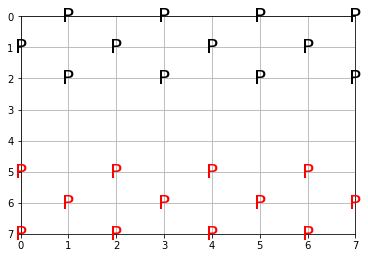

In [27]:
import ipywidgets as widgets  # Import widgets for interactive elements
from IPython.display import display  # Import display function to show widgets

import matplotlib.pyplot as plt  # Import matplotlib for plotting the board

def plot_board(board):
    """
    Plot the checkers board with pieces.

    Args:
    - board: A 2D list (8x8) representing the checkers board.
    """
    fig, ax = plt.subplots()  # Create a new figure and axes
    ax.set_xticks(range(8))  # Set x-axis ticks to range 0-7
    ax.set_yticks(range(8))  # Set y-axis ticks to range 0-7
    ax.set_xticklabels(range(8))  # Label x-axis ticks with numbers 0-7
    ax.set_yticklabels(range(8))  # Label y-axis ticks with numbers 0-7
    ax.grid(True)  # Enable grid on the plot

    for row in range(8):  # Iterate over each row
        for col in range(8):  # Iterate over each column
            piece = board[row][col]  # Get the piece at the current position
            if piece != '.':  # If the square is not empty
                color = 'red' if piece in 'rR' else 'black'  # Determine piece color
                queen = piece.isupper()  # Check if the piece is a queen
                ax.text(col, row, 'Q' if queen else 'P', ha='center', va='center', color=color, fontsize=20)  # Display piece

    plt.gca().invert_yaxis()  # Invert y-axis to match board orientation
    plt.show()  # Show the plot

def on_move_submit(b):
    """
    Handle the move submission by the user.

    Args:
    - b: The button widget that triggered the event.
    """
    global game  # Declare game as a global variable to modify it
    start_pos = (int(start_row.value), int(start_col.value))  # Get start position from widgets
    end_pos = (int(end_row.value), int(end_col.value))  # Get end position from widgets
    move = (start_pos, end_pos)  # Create a move tuple
    
    if move in game.generate_legal_moves(game.current_player):  # Check if the move is legal
        new_game = game.apply_move(move)  # Apply the move to get a new game state
        plot_board(new_game.board)  # Plot the updated board
        
        # Perform alpha-beta pruning to get the best move for the current player
        score, best_move = alpha_beta_pruning(new_game, depth, alpha, beta, maximizing_player)
        print(f"Suggested best move for {new_game.current_player}: {best_move} with score: {score}")
        
        # Switch to the next player
        game = new_game  # Update the global game state
    else:
        print("Invalid move. Please try again.")  # Inform the user if the move is invalid

# Create widgets for input
start_row = widgets.BoundedIntText(value=0, min=0, max=7, description='Start Row:')  # Widget for start row
start_col = widgets.BoundedIntText(value=0, min=0, max=7, description='Start Col:')  # Widget for start column
end_row = widgets.BoundedIntText(value=0, min=0, max=7, description='End Row:')  # Widget for end row
end_col = widgets.BoundedIntText(value=0, min=0, max=7, description='End Col:')  # Widget for end column
submit_button = widgets.Button(description='Submit Move')  # Button to submit the move

submit_button.on_click(on_move_submit)  # Attach the on_move_submit function to the button click event

# Display the widgets
display(start_row, start_col, end_row, end_col, submit_button)  # Display all widgets

# Plot the initial board
plot_board(initial_board)  # Plot the initial state of the board

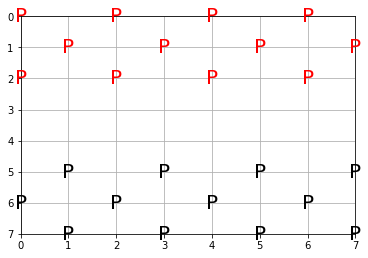

In [34]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

def plot_board(board):
    fig, ax = plt.subplots()
    ax.set_xticks(range(8))
    ax.set_yticks(range(8))
    ax.set_xticklabels(range(8))
    ax.set_yticklabels(range(8))
    ax.grid(True)

    for row in range(8):
        for col in range(8):
            piece = board[row][col]
            if piece != '.':
                color = 'red' if piece in 'rR' else 'black'
                queen = piece.isupper()
                ax.text(col, row, 'Q' if queen else 'P', ha='center', va='center', color=color, fontsize=20)

    plt.gca().invert_yaxis()
    fig.canvas.mpl_connect('button_press_event', on_click)
    plt.show()

def on_click(event):
    global selected_piece, game
    if event.xdata is None or event.ydata is None:
        return
    col, row = int(event.xdata), int(event.ydata)
    if selected_piece is None:
        if game.board[row][col] != '.':
            selected_piece = (row, col)
            print(f"Selected piece at {selected_piece}")
    else:
        move = (selected_piece, (row, col))
        if move in game.generate_legal_moves(game.current_player):
            game = game.apply_move(move)
            plot_board(game.board)
            selected_piece = None
        else:
            print("Invalid move. Please try again.")
            selected_piece = None

plot_board(initial_board)

In [74]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

# Function to plot the checkers board with pieces
def plot_board(board):
    fig, ax = plt.subplots()  # Create a new figure and axes
    ax.set_xticks(range(8))  # Set x-axis ticks to range 0-7
    ax.set_yticks(range(8))  # Set y-axis ticks to range 0-7
    ax.set_xticklabels(range(8))  # Label x-axis ticks with numbers 0-7
    ax.set_yticklabels(range(8))  # Label y-axis ticks with numbers 0-7
    ax.grid(True)  # Enable grid on the plot

    for row in range(8):  # Iterate over each row
        for col in range(8):  # Iterate over each column
            piece = board[row][col]  # Get the piece at the current position
            if piece != '.':  # If the square is not empty
                color = 'red' if piece in 'rR' else 'black'  # Determine piece color
                queen = piece.isupper()  # Check if the piece is a queen
                ax.text(col, row, 'Q' if queen else 'P', ha='center', va='center', color=color, fontsize=20)  # Display piece

    plt.gca().invert_yaxis()  # Invert y-axis to match board orientation
    fig.canvas.mpl_connect('button_press_event', on_click)  # Connect the click event to the on_click function
    plt.show()  # Show the plot

# Function to handle click events on the board
def on_click(event):
    global selected_piece, game  # Declare selected_piece and game as global variables to modify them
    if event.xdata is None or event.ydata is None:  # Check if the click is within the plot area
        return
    col, row = int(event.xdata), int(event.ydata)  # Get the column and row from the click event
    if selected_piece is None:  # If no piece is currently selected
        if game.board[row][col] != '.':  # Check if the clicked square contains a piece
            selected_piece = (row, col)  # Select the piece
            print(f"Selected piece at {selected_piece}")  # Print the selected piece position
    else:  # If a piece is already selected
        move = (selected_piece, (row, col))  # Create a move tuple with the selected piece and the clicked position
        if move in game.generate_legal_moves(game.current_player):  # Check if the move is legal
            game = game.apply_move(move)  # Apply the move to get a new game state
            plot_board(game.board)  # Plot the updated board
            selected_piece = None  # Reset the selected piece
            # Perform alpha-beta pruning to get the best move for the current player
            score, best_move = alpha_beta_pruning(game, depth, alpha, beta, maximizing_player)
            print(f"Suggested best move for {game.current_player}: {best_move} with score: {score}")  # Print the suggested best move
        else:  # If the move is not legal
            print("Invalid move. Please try again.")  # Inform the user that the move is invalid
            selected_piece = None  # Reset the selected piece

# Initialize the selected piece variable
selected_piece = None

# Create a grid of buttons to represent the checkers board
board_buttons = [[widgets.Button(description='', layout=widgets.Layout(width='50px', height='50px')) for _ in range(8)] for _ in range(8)]

# Function to update the button labels based on the board state
def update_board_buttons(board):
    for row in range(8):
        for col in range(8):
            piece = board[row][col]
            if piece == '.':
                board_buttons[row][col].description = ''
                board_buttons[row][col].style.button_color = None
            else:
                board_buttons[row][col].description = 'Q' if piece.isupper() else 'P'
                board_buttons[row][col].style.button_color = 'red' if piece in 'rR' else 'black'

# Function to handle button clicks
def on_button_click(b):
    global selected_piece, game
    for row in range(8):
        for col in range(8):
            if board_buttons[row][col] == b:
                if selected_piece is None:
                    piece = game.board[row][col]
                    # Check if the piece belongs to the current player
                    if piece != '.':  # First check if there's a piece
                        if piece.lower() == game.current_player.lower()[0]:
                            selected_piece = (row, col)
                            print(f"Selected piece at {selected_piece}")
                        else:
                            print(f"Not your piece! Current player: {game.current_player}")
                    else:
                        print("No piece at this position!")
                else:
                    move = (selected_piece, (row, col))
                    legal_moves = game.generate_legal_moves(game.current_player)
                    if move in legal_moves:
                        game = game.apply_move(move)
                        update_board_buttons(game.board)
                        selected_piece = None
                        print(f"Move made from {move[0]} to {move[1]}")
                        # After player's move, calculate and show AI's suggestion
                        score, best_move = alpha_beta_pruning(game, depth, alpha, beta, maximizing_player)
                        print(f"Suggested best move for {game.current_player}: {best_move} with score: {score}")
                    else:
                        print(f"Invalid move {move}. Legal moves are: {legal_moves}")
                        selected_piece = None
                return  # Exit the loop once we've found the button

# Attach the click event handler to each button
for row in range(8):
    for col in range(8):
        board_buttons[row][col].on_click(on_button_click)

# Display the board buttons in a grid layout
board_grid = widgets.GridBox(children=[board_buttons[row][col] for row in range(8) for col in range(8)],
                             layout=widgets.Layout(grid_template_columns='repeat(8, 50px)'))

# Update the buttons to reflect the initial board state
update_board_buttons(initial_board)

# Display the board
display(board_grid)
# Flip the board to have black pieces on top and red pieces on bottom
initial_board = initial_board[::-1]

# Swap 'r' and 'b' to switch the positions of the pieces
for row in initial_board:
    for i in range(len(row)):
        if row[i] == 'r':
            row[i] = 'b'
        elif row[i] == 'b':
            row[i] = 'r'
        elif row[i] == 'R':
            row[i] = 'B'
        elif row[i] == 'B':
            row[i] = 'R'

# Update the game state with the new board
game.board = initial_board
game.current_player = 'b'  # Set the current player to black

# Modify the update_board_buttons function to change colors
def update_board_buttons(board):
    for row in range(8):
        for col in range(8):
            piece = board[row][col]
            button = board_buttons[row][col]
            if piece == '.':
                button.description = ''
                button.style.button_color = None
            else:
                button.description = 'Q' if piece.isupper() else 'P'
                # Change the colors of the pieces
                if piece in 'rR':
                    button.style.button_color = 'black'
                    button.style.font_weight = 'bold'
                    button.style.font_size = '16px'
                    button.style.font_color = 'white'
                else:
                    button.style.button_color = 'red'
                    button.style.font_weight = 'bold'
                    button.style.font_size = '16px'
                    button.style.font_color = 'white'

# Update the display to reflect the changes
update_board_buttons(game.board)

GridBox(children=(Button(description='P', layout=Layout(height='50px', width='50px'), style=ButtonStyle(button…

Not your piece! Current player: b
Selected piece at (5, 2)
Invalid move ((5, 2), (4, 1)). Legal moves are: []
Selected piece at (5, 2)
Invalid move ((5, 2), (2, 3)). Legal moves are: []
